In [1]:
import os
import numpy as np
from tqdm import tqdm
import math
import pandas as pd
import cv2
from scipy.integrate import simps
import matplotlib.pyplot as plt
from skimage.transform import pyramid_gaussian
import glob2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import saliency as saliency
import pickle

In [2]:
def diverging_norm(img):
    """Returns image with positive and negative values."""
    assert isinstance(img, np.ndarray), "img should be a numpy array"
    shp = img.shape
    if len(shp)< 2:
        raise ValueError("Array should have 2 or 3 dims!")
    if len(shp)==2:
        imgmax = np.absolute(img).max()
        img = img/float(imgmax)
    else:
        img = saliency.VisualizeImageDiverging(img)
    return img


def plot_single_img(img,
                    ax=False,
                    norm=diverging_norm,
                    show_axis=False,
                    grayscale=False,
                    cmap='gray',
                    title='',
                    fig_size=(4,4)):
    plt.figure(figsize=fig_size)
    if norm:
        img = norm(img)
    if not show_axis:
        plt.axis('off')
    plt.imshow(img, cmap=cmap)
    if title:
        plt.title(title)
        
def image_generator(directory, res, batch_size=1):
    test_datagen = ImageDataGenerator()
    image_generator = test_datagen.flow_from_directory(
            directory,
            target_size=(res, res),
            color_mode= 'rgb',
            batch_size= batch_size,  
            class_mode= 'categorical',
            shuffle= False, 
            seed= 1337)
    return image_generator

In [3]:
def compute_perturbations(img_input, model, batch_size, explained_class, heatmap,
                          kernel_size=3, draw_mode=0, num_regions=30, num_perturbs=50):
    """
    Args:
        img_input (array): original image
        model (PyTorch model): pretrained model
        batch_size (int): batch size to run per epoch
        explained_class (int): index of the class to be explained
        heatmap (array): attribution heatmap for the image
        kernel_size (int): size of the window of each perturbation
        draw_mode (int): perturb draw mode: 0 - uniform; 1 - gaussian according to image stats
        num_regions (int): number of regions to perturbate
        num_perturbs (int): number of random perturbations to evaluate
    """
    # Find average pooling with kernel
    img_h, img_w = heatmap.shape
    avg_values = -np.inf * np.ones(img_h * img_w)

    for h in range(img_h - kernel_size):
        for w in range(img_w - kernel_size):
            avg_values[h+w*img_h] = np.mean(np.abs(heatmap[h:h+kernel_size, w:w+kernel_size]))
    most_relevant_idxs = np.argsort(-avg_values)   # most relevant first

    # Load original image
    img = img_input  # TODO: maybe take transform as input?
    if draw_mode == 1:   # from gaussian according to img stats
        # compute mean and std dev. from each channel
        channel_stats = np.zeros((2,3))
        for c in range(3):
            channel_stats[0, c]= np.mean(img[c,:,:])
            channel_stats[1, c]= np.std(img[c,:,:])
            if np.isnan(channel_stats[1, c]):
                channel_stats[1, c] = 1e-3

    # Initialize perturb scores
    perturb_scores = []
    img_pertubations = []

    # Select the most relevant point to perform the perturbation
    bad_idxs = set()
    for region_idx in range(num_regions):
        found = False
        for i, kernel_idx in enumerate(most_relevant_idxs):
            if kernel_idx not in bad_idxs:
                # get coordinates of point
                width = int(math.floor(kernel_idx / img_h))
                height = int(kernel_idx - width * img_h)

                # ignore if the point is beyond the boundaries of kernel
                if (img_h - height) <= kernel_size or (img_w- width) <= kernel_size:
                    continue

                # mark overlapping neighboring points as not to use in bad_idxs
                for h in range(-kernel_size + 1, kernel_size):
                    for w in range(-kernel_size + 1, kernel_size):
                        bad_idxs.add((height + h) + (width + w) * img_h)
                
                found=True
                break
        if not found:  # no more useful points
            print('no more useful points')
            break

        # Prepare perturbation copies
        perturbs = []
        perturbs_imgs = [tf.zeros_like(img_input) for _ in range(num_perturbs)]

        # Compute the perturbation
        for i in range(num_perturbs):
            if draw_mode == 0:   # uniform
                # draw randomly from uniform distribution, space is 0,255
                perturb = np.random.uniform(low=0, high=255, size=(kernel_size, kernel_size))
                perturb = np.repeat(perturb[..., np.newaxis], 3, axis=-1)
            elif draw_mode == 1:   # from gaussian according to img stats
                perturb = np.zeros((3, kernel_size, kernel_size))
                for c in range(3):
                    perturb[c] = np.random.normal(
                        loc=channel_stats[0, c],    # mean
                        scale=channel_stats[1, c],  # std dev
                        size=(kernel_size, kernel_size)
                    )
                # Ensure perturb does not exceed bounds
                perturb = np.maximum(perturb, np.zeros_like(perturb))       # element-wise max(p, 0)
                perturb = np.minimum(perturb, 255 * np.ones_like(perturb))  # element-wise min(p, 255)
                perturb = np.moveaxis(perturb, 0, -1)
            else:
                print('Invalid perturb draw mode')
                exit()
            
            # Apply the perturbation to the current point
            perturbs_imgs[i] = img
            middle_img = img
            middle_img[height:height+kernel_size, width:width+kernel_size, :] = perturb
            perturbs_imgs[i] = middle_img
            perturbs.append(perturb)
            
        # Perform the classification for the perturbations
        actual_perturb_idx, mean_score = classify_perturbations(perturbs_imgs, model, explained_class)

        # Apply the actual perturbation on image
        actual_perturb = perturbs[actual_perturb_idx]
        actual_middle_img = img
        actual_middle_img[height:height+kernel_size, width:width+kernel_size, :] = perturb
        img = actual_middle_img
        
        # Save the mean scores of the perturbations
        perturb_scores.append(mean_score)
    return perturb_scores

In [4]:
def classify_perturbations(data_loader, model, explained_class):
    # Find the scores for all perturbation candidate    
    all_scores = []
    global dataloader 
    dataloader = data_loader
    out = m.predict(np.array(data_loader))
    scores = out[:, explained_class]
    all_scores.append(scores)
    all_scores = np.array(all_scores)
    all_scores = np.concatenate(all_scores)

    # Find the index of the perturbation closest to the median
    mean_score = np.mean(all_scores)
    median = np.median(all_scores)
    best_idx = 0
    best_val = np.inf
    for i in range(len(all_scores)):   # for every perturbation candidate
        value = math.fabs(all_scores[i] - median)  # absolute distance to median
        if value < best_val:
            best_val = value
            best_idx = i
    return best_idx, mean_score


In [5]:
OUTPUT_DIR = "./OUT/"

INPUT_SAL = "/home/maia/Documents/Universidade/Universidade/UNIVERSIDADE/EXPERIMENTO/2EXPLAIN_NEW_VGG_CUSTOM/CUSTOMCNN/XRAY/OUT/CUSTOM-XRAY-TRUE/*"
METODOS_FILES = glob2.glob(INPUT_SAL)

MODEL = "/home/maia/Documents/Universidade/Universidade/UNIVERSIDADE/EXPERIMENTO/1TRAIN_NEW_VGG_CUSTOM/CUSTOMCNN/X-RAY/CUSTOM-CNN-XRAY-TRUE/baseline_model.h5"


In [6]:
m = tf.keras.models.load_model(MODEL)
m.summary()
conv_layer = m.get_layer('conv2d_2')
model = tf.keras.models.Model([m.inputs], [conv_layer.output, m.output])   

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 32)        51232     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0

array([[9.9958819e-01, 4.1180255e-04]], dtype=float32)

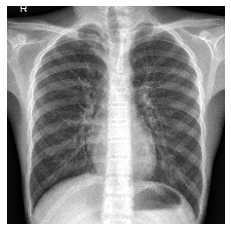

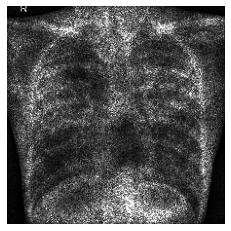

In [7]:
originalPath = glob2.glob(INPUT_SAL[:-1] + 'Original/*.png')[0]
heatmap_path = originalPath.replace("Original", "IntegratedGradients")
org_img = cv2.imread(originalPath)
plot_single_img(org_img)

heatmap = cv2.imread(heatmap_path)
plot_single_img(heatmap)

logits = m.predict(np.expand_dims(org_img, axis=0))
logits

In [8]:
tecnicas_scores_dict = {}
tecnicas_plots_dict = {}
for tecnica_path in METODOS_FILES:
    print(tecnica_path)
    tecnica = tecnica_path.split("/")[-1]
    if(tecnica == "Original"):
        continue
    num_regions=30
    orig_images = glob2.glob(INPUT_SAL[:-1] + 'Original/*.png')
    dataset_size = len(orig_images)
    all_perturb_scores = np.ones((dataset_size, num_regions + 1)) * np.inf

    for originalPathIdx, originalPath in  enumerate(orig_images):
        print(originalPathIdx)
        heatmap_path = originalPath.replace("Original", tecnica)
        org_img = cv2.imread(originalPath)

        heatmap = cv2.imread(heatmap_path)
        heatmap_grey = cv2.cvtColor(heatmap, cv2.COLOR_BGR2GRAY)

        # Save top score as the starting perturb score as the first region
        logits = m.predict(np.expand_dims(org_img, axis=0))
        predicted_class = logits.argmax(axis=1)
        all_perturb_scores[originalPathIdx, 0] = np.max(logits)

        mean_perturb_scores = compute_perturbations(
            img_input=org_img,
            model=m,
            batch_size=50,
            draw_mode=1,
            explained_class=predicted_class,
            num_regions=num_regions,
            kernel_size=15,
            heatmap=heatmap_grey
        )
        all_perturb_scores[originalPathIdx, 1:(len(mean_perturb_scores)+1)] = mean_perturb_scores
    tecnicas_scores_dict[tecnica] = all_perturb_scores
    df = pd.DataFrame(all_perturb_scores)
    line = df.mean()
    tecnicas_plots_dict[tecnica] = line
    images_plot[tecnica] = images

/home/maia/Documents/Universidade/Universidade/UNIVERSIDADE/EXPERIMENTO/2EXPLAIN_NEW_VGG_CUSTOM/CUSTOMCNN/XRAY/OUT/CUSTOM-XRAY-TRUE/RISE
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
/home/maia/Documents/Universidade/Universidade/UNIVERSIDADE/EXPERIMENTO/2EXPLAIN_NEW_VGG_CUSTOM/CUSTOMCNN/XRAY/OUT/CUSTOM-XRAY-TRUE/Original
/home/maia/Documents/Universidade/Universidade/UNIVERSIDADE/EXPERIMENTO/2EXPLAIN_NEW_VGG_CUSTOM/CUSTOMCNN/XRAY/OUT/CUSTOM-XRAY-TRUE/Input-Grad
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
/home/maia/Documents/Universidade/Universidade/UNIVERSIDADE/EXPERIMENTO/2EXPLAIN_NEW_VGG_CUSTOM/CUSTOMCNN/XRAY/OUT/CUSTOM-XRAY-TRUE/GradCam
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
/home/maia/Document

In [13]:
df_plots = pd.DataFrame(tecnicas_plots_dict)
df_plots.to_csv("df_plots.csv")

a_file = open("dict_scores.pkl", "wb")
pickle.dump(tecnicas_scores_dict, a_file)
a_file.close()


<AxesSubplot:>

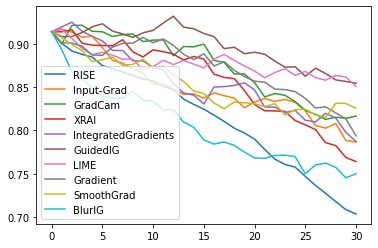

In [14]:
df_plots = pd.DataFrame(tecnicas_plots_dict)
df_plots.plot()